In [241]:
#GOOOOOOD
import numpy as np
from scipy import stats




In [242]:
import random as random
from statistics import mean
import copy as copy
import plotly.express as px
import pandas as pd  
from timeit import default_timer as timer
from copy import deepcopy

MAX_DEPTH = 5
MIN_DEPTH = 2
POP_SIZE = 60

#DEFINE FUNCTIONS
def mult(x, y): return x*y
def add(x, y):  return x+y
def div(x, y):  return x/y
def sub(x, y):  return x-y

FUNCTIONS = [mult, add, sub]
OPS = ['*', '+', '/', '-']
TERMINALS = ['x', -2, -1, 0, 1, 2]

#f of x function for optimal solution
def optimal(x):
    return x*x*x + 3*x + 10

#Dataset (100 data points)
def dataset():
    dataset = []
    for x in range(-100, 101, 2):
        x = x / 100
        dataset.append([x, optimal(x)])
    
    return dataset

#EXPRESSION TREE CLASS
class ExpressionTree():

    #initalise expression tree
    def __init__(self, value = None, left = None, right = None):
        self.value = value
        self.left = left
        self.right = right
        
    #returns size of the tree
    def size(self): 
        if self.value in TERMINALS: return 1
        
        #Recursively go down left subtree and count size
        if (self.left): left = self.left.size()   
        else: left = 0 

        #Recursively go down right subtree and count size
        if (self.right): right = self.right.size() 
        else: right = 0
            
        return 1 + left + right

    #Creates a random subtree. Two different methods used here.
    def random_tree(self, grow, max_depth, depth = 0): 
        
        #Tree still needs to become larger, add a operator
        if depth < MIN_DEPTH or (depth < max_depth and not grow): 
            self.value = FUNCTIONS[random.randint(0, len(FUNCTIONS)-1)]

        #Tree has reached max size (Stop growing)
        elif depth >= max_depth:   
            self.value = TERMINALS[random.randint(0, len(TERMINALS)-1)]
        
        # intermediate depth, grow
        else: 
            if random.random() > 0.5: 
                self.value = TERMINALS[random.randint(0, len(TERMINALS)-1)]
            else:
                self.value = FUNCTIONS[random.randint(0, len(FUNCTIONS)-1)]
        
        if self.value in FUNCTIONS:
            self.left = ExpressionTree()          
            self.left.random_tree(grow, max_depth, depth = depth + 1)            
            self.right = ExpressionTree()
            self.right.random_tree(grow, max_depth, depth = depth + 1)
    
    #Mutation probabilty acts on every node in the subtree
    def mutation(self):
        #mutate
        if random.random() < 0.2:
            self.random_tree(grow = True, max_depth = 2)
        
        #else if traverse to new node in tree.
        elif self.left: 
            self.left.mutation()
        elif self.right: 
            self.right.mutation() 
    
    def evaluate_expression(self, x): 
        if (self.value in FUNCTIONS): 
            return self.value(self.left.evaluate_expression(x), self.right.evaluate_expression(x))
        elif self.value == 'x': 
            return x
        else: 
            return self.value
        
    def build_subtree(self): # count is list in order to pass "by reference"
        t = ExpressionTree()
        t.value = self.value
        if self.left:  
            t.left  = self.left.build_subtree()
        if self.right: 
            t.right = self.right.build_subtree()
        return t
                        
    def scan_tree(self, count, second): # note: count is list, so it's passed "by reference"
        count[0] -= 1            
        if count[0] <= 1: 
            if not second: # return subtree rooted here
                return self.build_subtree()
            else: # glue subtree here
                self.value  = second.value
                self.left  = second.left
                self.right = second.right
        else:  
            ret = None              
            if self.left  and count[0] > 1: ret = self.left.scan_tree(count, second)  
            if self.right and count[0] > 1: ret = self.right.scan_tree(count, second)  
            return ret
        
    def crossover(self, other): # xo 2 trees at random nodes
        if random.random() < 0.8:
            second = other.scan_tree([random.randint(1, other.size())], None) # 2nd random subtree
            self.scan_tree([random.randint(1, self.size())], second) # 2nd subtree "glued" inside 1st tree
            
    #LOCAL SEARCH 1
    def local_search_one(self, head, dataset):

        old_tree = copy.deepcopy(head)

        if(self.value not in FUNCTIONS and self.value != "x"):
            self.value += 0.1
            #if the trees fitness is better
            if(individual_fitness(head, dataset) > individual_fitness(old_tree, dataset)):
                #Revert value back to original
                self.value -= 0.1
            
            return

        #Traverse
        if(self.left):  
            self.left.local_search_one(old_tree, dataset)
        if(self.right): 
            self.right.local_search_one(old_tree, dataset)


    
#TRAVERSE TREE BY IN ORDER FASHION
def inorder(node):
        
    if(node.left): inorder(node.left)
    if(node.value in FUNCTIONS):
        print(node.value.__name__)
    else:
        print(node.value)
    if(node.right): inorder(node.right)

#INITIALISE POPULATION
def initalise_population(): 
    population = []
    for md in range(3, MAX_DEPTH + 1):

        for i in range(int(POP_SIZE/6)):
            rand_tree = ExpressionTree()
            rand_tree.random_tree(grow = True, max_depth = md) # full
            population.append(rand_tree) 
        for i in range(int(POP_SIZE/6)):
            rand_tree = ExpressionTree()
            rand_tree.random_tree(grow = False, max_depth = md) # grow
            population.append(rand_tree) 

    return population

In [243]:
#LOCAL SEARCH TECHNIQUES

In [244]:
#When a tree is print in an in order fashion it is valid when
# 1. The first node is 'x' or a number
# 2. After the first output each node is an operator followed by operand followed by operator......
# 3. Last node is 'x' or a number
# Example: [x, +, 5, *, 2, -0, *, 6]
#.          0. 1. 2. 3. 4.  5. 6. 7
def validate_helper(tree):
    treeElements = []
    validate_tree(tree, treeElements)
    operators = ['add', 'sub', 'mult']
    
    for i in range(0, (len(treeElements) - 1)):
        if (i % 2 == 0):
            if(treeElements[i] in operators):
                return False
        
        else:
            if(treeElements[i] not in operators):
                return False
    
    if (treeElements[0] in FUNCTIONS):
        return False
    
    return True
                
def validate_tree(node, treeElements):
    
    if(node.left): validate_tree(node.left, treeElements)
        
    if(node.value in FUNCTIONS):
        treeElements.append(str(node.value.__name__))
    else:
         treeElements.append(str(node.value))
        
    if(node.right): validate_tree(node.right, treeElements)


def individual_fitness(individual, dataset):
    mae = 1 / (1 + mean([abs(individual.evaluate_expression(ds[0] - ds[1])) for ds in dataset]))
    return mae

def individual_fitness_parsimony(individual, dataset):
    mae = 1 / (1 + mean([abs(individual.evaluate_expression(ds[0] - ds[1])) for ds in dataset]) + 0.01*individual.size())
    return mae

#LOCAL SEARCH 2
def local_search_two(head, node, dataset):
    
    #Iterate through tree
    if(node.left):  local_search_two(head, node.left, dataset)
    
    old_tree = copy.deepcopy(head)
    #if value is an operator delete subtree 
    if(node.left):
        if(node.left.value in FUNCTIONS):
            #Copy subtree
            temp = copy.deepcopy(node.left)
            #Set node to None
            node.left = None
            
            #Validate if new tree is valid
            if(validate_helper(head)):
                print("valid")
                #if new tree is valid but worse set it to previous state
                if(individual_fitness(head, dataset) > individual_fitness(old_tree, dataset)):
                    node.left = temp
            else: #if new tree is not valid set back to previous state
                node.left = temp;
    
    #if value is an operator delete subtree 
    elif(node.right):
        if(node.right.value in FUNCTIONS):
            #Copy subtree
            temp = copy.deepcopy(node.right)
            #Set node to None
            node.right = None
            
            #Validate if new tree is valid
            if(validate_helper(head)):
                print("valid")
                #if new tree is valid but worse set it to previous state
                if(individual_fitness(head, dataset) > individual_fitness(old_tree, dataset)):
                    node.right = temp
            else: #if new tree is not valid set back to previous state
                node.right = temp;
                    
    if(node.right): local_search_two(head, node.right, dataset)
    
                
#TEST

#Create random tree
tree = ExpressionTree()
tree.random_tree(grow = True, max_depth = 3)

# data = dataset()

# # print("OLD TREE")
# # inorder(tree)
# # print("\n\n\n")

# tree.local_search_one(tree, data)

# individual_fitness(tree, data)

# print("\n\n\n")
# print("NEW TREE")
# inorder(tree)
#print(validate_helper(tree))
#inorder(tree)
#local_search_two(tree, tree, dataset)
#print("\n\n\n\n")
#inorder(tree)


In [245]:
#FITNESS FUNCTION

#calculate mean absolute error

def calculate_fitness(pop, dataset):
    
    fitness = []
    for individual in pop:
        mae = 1 / (1 + mean([abs(individual.evaluate_expression(ds[0]) - ds[1]) for ds in dataset]))
        fitness.append(mae)
        
    return fitness

#calculate mean average error
def calculate_fitness_parsimory(pop, dataset):
    
    fitness = []
    for individual in pop:
        mae = 1 / (1 + (mean([abs(individual.evaluate_expression(ds[0]) - ds[1]) for ds in dataset])))
        fitness.append(mae)
    
    fitness = parsimory_pressure(fitness, pop)
    return fitness

def parsimory_pressure(fitness, pop):
    i = 0
    for individual in pop:
        fitness[i] += 0.01*individual.size()
        
    return fitness
    

In [246]:
#TOURNAMENT SELECTION
def tournament_selection(pop, fitness):
    best_index = -1
    #select 5 individuals
    for i in range(0, 5):
        rand_index = random.randint(0, len(fitness) - 1)
        
        if (best_index == -1) or (fitness[rand_index] > fitness[best_index]):
            best_index = rand_index
    
    #return best individual found from tournament
    return deepcopy(pop[best_index])
    

In [247]:

#GENETIC ALGORITHMS


In [248]:



#GENETIC ALGORITHM ONLY CROSSOVER

#dataframe = pd.DataFrame(data, columns=[names[0]]) 
#dataframe.insert(i, names[i], data, True)
#import pandas as pd
#names = ["algorithm-1", "algorithm-2", "algorithm-3", "algorithm-4"]

all_mae = []
all_comp_cost = []
all_tree_size = []

In [249]:
def only_crossover():
    
    #intialise population
    pop = initalise_population()
    data = dataset()
    fitnesses = calculate_fitness(pop, data)

    best_run_tree = None #Stores best tree found in all generations
    best_run_fitness = -1 #Stores fitness of best tree found in all generations
    best_run_generation = 0 #Stores generation where best tree found

    best_from_each_gen = [] #Stores best tree found in each generations
    best_fitness_each_gen = [] #Stores fitness of best tree found in each generations
    avg_size_of_each_gen = [] #Stores average node size of each new population 

    #loop over generations
    for generation in range(0, 50):
        new_pop = []

        #ELITISM SELECT
        new_pop.append(pop[fitnesses.index(min(fitnesses))])

        #loop over each individual in population
        for individual in pop[1:]:
            #Parent select
            parent1 = tournament_selection(pop, fitnesses)
            parent2 = tournament_selection(pop, fitnesses)

            #crossover
            parent1.crossover(parent2)

            #mutation
            parent1.mutation()

            #add child to population
            new_pop.append(parent1)

        #---------Calculate Stats------------#

        #Calculate best run in new_pop
        generation_best_index = fitnesses.index(min(fitnesses))
        generation_best = pop[generation_best_index]

        #Calculate if its best solution found so far
        if ((best_run_fitness == -1) or (fitnesses[generation_best_index] < best_run_fitness)):
            best_run_tree = pop[generation_best_index]
            best_run_fitness = fitnesses[generation_best_index]
            best_run_generation = generation

            #print("-----------BEST RUN FOUND-----------")
            #print("GENERATION: ", generation)
            #print("FITNESS: ", best_run_fitness)
            #print("--------------THE TREE--------------")
            #inorder(best_run_tree)


        #add best solution from generation to best from each gen    
        best_from_each_gen.append(pop[generation_best_index])
        best_fitness_each_gen.append(min(fitnesses))

        #calculate mean size
        size = 0;
        for count in range(len(pop)):
            size += pop[count].size()
        avg_size_of_each_gen.append(size/len(pop))


        #End generation
        pop = new_pop
        fitnesses = calculate_fitness(pop, data)
        
    return best_run_tree



In [250]:

#TESTING 

bestRunsTree = []
bestRunsTime = []

for i in range(10):
    print(i)
    start = timer()
    bestRunsTree.append(only_crossover())
    end = timer()
    bestRunsTime.append(end - start)

treeSizes = []
mae = []

data = dataset()

for i in range(len(bestRunsTree)):
    treeSizes.append(bestRunsTree[i].size())
    mae.append(individual_fitness(bestRunsTree[i], data))

all_mae.insert(len(all_mae), mae)
all_comp_cost.insert(len(all_comp_cost), bestRunsTime)
all_tree_size.insert(len(all_tree_size), treeSizes)

0
1
2
3
4
5
6
7
8
9


In [251]:

#GRAPHING


In [252]:
#Mean absolute error of best solution with crossover and no parsimony pressure

#x is generations
#y is node size
xAxis = []
for i in range(len(bestRunsTree)):
    xAxis.append(i + 1)

data = {'Test Instance': xAxis,
        'Fitness (Mean Absolute Error)': mae}

df = pd.DataFrame(data)  


fig = px.scatter(df, x = "Test Instance", y="Fitness (Mean Absolute Error)",
             title="Mean absolute error of best solution with crossover and no parsimony pressure")

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)
average = sum(mae) / len(mae)
#fig.add_hline(average)

fig.add_shape(type='line',
                x0=1,
                y0=average,
                x1=10,
                y1=average,
                line=dict(color='Blue',),
                xref='x',
                yref='y'
)

fig.write_image("with_crossover-mae.pdf")


fig.show()

In [253]:
#Tree size of best solution with crossover and no parsimony pressure

data = {'Test Instance': xAxis,
        'Tree size (Amount of nodes)': treeSizes}

df = pd.DataFrame(data)  


fig = px.scatter(df, x = "Test Instance", y="Tree size (Amount of nodes)",
             title="Tree size of best solution with crossover and no parsimony pressure")

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)
average = sum(treeSizes) / len(treeSizes)
#fig.add_hline(average)

fig.add_shape(type='line',
                x0=1,
                y0=average,
                x1=10,
                y1=average,
                line=dict(color='Blue',),
                xref='x',
                yref='y'
)
fig.write_image('with_crossover-treesize.pdf')
fig.show()

In [254]:
#Time to run each test instance with crossover and no parsimony pressure

data = {'Test Instance': xAxis,
        'Time (Seconds)': bestRunsTime}

df = pd.DataFrame(data)  


fig = px.scatter(df, x = "Test Instance", y="Time (Seconds)",
             title="Time to run each test instance with crossover and no parsimony pressure")

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)
average = sum(bestRunsTime) / len(bestRunsTime)
#fig.add_hline(average)

fig.add_shape(type='line',
                x0=1,
                y0=average,
                x1=10,
                y1=average,
                line=dict(color='Blue',),
                xref='x',
                yref='y'
)
fig.write_image('with_crossover-time.pdf')
fig.show()

In [255]:
# xAxis = []
# for i in range(len(best_fitness_each_gen)):
#     xAxis.append(i)

# data = {'Generation': xAxis,
#         'Fitness (Mean Absolute Error)': best_fitness_each_gen}

# df = pd.DataFrame(data)  

# fig = px.line(df, x = "Generation", y="Fitness (Mean Absolute Error)",
#              title="Mean absolute error of best solution per generation without parsimony pressure")
# fig.show()

In [256]:
# xAxis = []
# for i in range(len(avg_size_of_each_gen)):
#     xAxis.append(i)

# data = {'Generation': xAxis,
#         'Tree size (Avg number of Nodes)': avg_size_of_each_gen}

# df = pd.DataFrame(data)  

# fig = px.line(df, x = "Generation", y="Tree size (Avg number of Nodes)",
#              title="Average tree node count per generation without parsimony pressure")
# fig.show()

In [257]:





#GENETIC ALGORITHM WITH CROSSOVER (WITH PARSIMONY PRESSURE)






In [258]:

def with_crossover_parsimony_pressure():
    #intialise population
    pop = initalise_population()
    data = dataset()
    fitnesses = calculate_fitness_parsimory(pop, data)

    best_run_tree = None #Stores best tree found in all generations
    best_run_fitness = -1 #Stores fitness of best tree found in all generations
    best_run_generation = 0 #Stores generation where best tree found

    best_from_each_gen = [] #Stores best tree found in each generations
    best_fitness_each_gen = [] #Stores fitness of best tree found in each generations
    avg_size_of_each_gen = [] #Stores average node size of each new population 

    #loop over generations
    for generation in range(0, 100):
        new_pop = []

        #ELITISM SELECT
        new_pop.append(pop[fitnesses.index(min(fitnesses))])

        #loop over each individual in population
        for individual in pop[1:]:
            #Parent select
            parent1 = tournament_selection(pop, fitnesses)
            parent2 = tournament_selection(pop, fitnesses)

            #crossover 
            parent1.crossover(parent2)

            #mutation
            parent1.mutation()

            #add child to population
            new_pop.append(parent1)

        #----------End Generation------------#

        #---------Calculate Stats------------#

        #Calculate best run in new_pop
        generation_best_index = fitnesses.index(min(fitnesses))
        generation_best = pop[generation_best_index]

        #Calculate if its best solution found so far
        if ((best_run_fitness == -1) or (fitnesses[generation_best_index] < best_run_fitness)):
            best_run_tree = pop[generation_best_index]
            best_run_fitness = fitnesses[generation_best_index]
            best_run_generation = generation

            #print("-----------BEST RUN FOUND-----------")
            #print("GENERATION: ", generation)
            #print("FITNESS: ", best_run_fitness)
            #print("--------------THE TREE--------------")
            #inorder(best_run_tree)


        #add best solution from generation to best from each gen    
        best_from_each_gen.append(pop[generation_best_index])
        best_fitness_each_gen.append(min(fitnesses))

        #calculate mean size
        size = 0;
        for count in range(len(pop)):
            size += pop[count].size()
        avg_size_of_each_gen.append(size/len(pop))


        #End generation
        pop = new_pop
        fitnesses = calculate_fitness_parsimory(pop, data)
    return best_run_tree

In [259]:
#TESTING 

bestRunsTree = []
bestRunsTime = []

for i in range(10):
    start = timer()
    print(i)
    bestRunsTree.append(with_crossover_parsimony_pressure())
    end = timer()
    bestRunsTime.append(end - start)

treeSizes = []
mae = []

data = dataset()

for i in range(len(bestRunsTree)):
    treeSizes.append(bestRunsTree[i].size())
    mae.append(individual_fitness(bestRunsTree[i], data))

all_mae.insert(len(all_mae), mae)
all_comp_cost.insert(len(all_comp_cost), bestRunsTime)
all_tree_size.insert(len(all_tree_size), treeSizes)

0
1
2
3
4
5
6
7
8
9


In [260]:

#GRAPHING


In [261]:
#Mean absolute error of best solution with crossover and parsimony pressure

xAxis = []
for i in range(len(bestRunsTree)):
    xAxis.append(i+1)

data = {'Test Instance': xAxis,
        'Fitness (Mean Absolute Error)': mae}

df = pd.DataFrame(data)  


fig = px.scatter(df, x = "Test Instance", y="Fitness (Mean Absolute Error)",
             title="Mean absolute error of best solution with crossover and parsimony pressure")

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)
average = sum(mae) / len(mae)
#fig.add_hline(average)

fig.add_shape(type='line',
                x0=1,
                y0=average,
                x1=10,
                y1=average,
                line=dict(color='Blue',),
                xref='x',
                yref='y'
)
fig.write_image('with_crossover_parsimonypressure-mae.pdf')
fig.show()

In [262]:
#Tree size of best solution with crossover and parsimony pressure

data = {'Test Instance': xAxis,
        'Tree size (Amount of nodes)': treeSizes}

df = pd.DataFrame(data)  


fig = px.scatter(df, x = "Test Instance", y="Tree size (Amount of nodes)",
             title="Tree size of best solution with crossover and parsimony pressure")

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)
average = sum(treeSizes) / len(treeSizes)
#fig.add_hline(average)

fig.add_shape(type='line',
                x0=1,
                y0=average,
                x1=10,
                y1=average,
                line=dict(color='Blue',),
                xref='x',
                yref='y'
)
fig.write_image('with_crossover_parsimonypressure-treesize.pdf')
fig.show()

In [263]:
#Time to run each test instance with crossover and parsimony pressure

data = {'Test Instance': xAxis,
        'Time (Seconds)': bestRunsTime}

df = pd.DataFrame(data)  


fig = px.scatter(df, x = "Test Instance", y="Time (Seconds)",
             title="Time to run each test instance with crossover and parsimony pressure")

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)
average = sum(bestRunsTime) / len(bestRunsTime)
#fig.add_hline(average)

fig.add_shape(type='line',
                x0=1,
                y0=average,
                x1=10,
                y1=average,
                line=dict(color='Blue',),
                xref='x',
                yref='y'
)
fig.write_image('with_crossover_parsimonypressure-time.pdf')
fig.show()

In [264]:
# xAxis = []
# for i in range(len(best_fitness_each_gen)):
#     xAxis.append(i)

# data = {'Generation': xAxis,
#         'Fitness (Mean Absolute Error)': best_fitness_each_gen}

# df = pd.DataFrame(data)  

# fig = px.line(df, x = "Generation", y="Fitness (Mean Absolute Error)",
#              title="Mean absolute error of best solution per generation with parsimony pressure")
# fig.show()

In [265]:
# xAxis = []
# for i in range(len(avg_size_of_each_gen)):
#     xAxis.append(i)

# data = {'Generation': xAxis,
#         'Tree size (Avg number of Nodes)': avg_size_of_each_gen}

# df = pd.DataFrame(data)  

# fig = px.line(df, x = "Generation", y="Tree size (Avg number of Nodes)",
#              title="Average tree node count per generation with parsimony pressure")
# fig.show()

In [266]:





#GENETIC ALGORITHM WITHOUT CROSSOVER






In [267]:
def without_crossover():
    #intialise population
    pop = initalise_population()
    data = dataset()
    fitnesses = calculate_fitness(pop, data)

    best_run_tree = None #Stores best tree found in all generations
    best_run_fitness = -1 #Stores fitness of best tree found in all generations
    best_run_generation = 0 #Stores generation where best tree found

    best_from_each_gen = [] #Stores best tree found in each generations
    best_fitness_each_gen = [] #Stores fitness of best tree found in each generations
    avg_size_of_each_gen = [] #Stores average node size of each new population 

    #loop over generations
    for generation in range(0, 50):
        new_pop = []

        #ELITISM SELECT
        new_pop.append(pop[fitnesses.index(min(fitnesses))])

        #loop over each individual in population
        for individual in pop[1:]:
            #Parent select
            parent1 = tournament_selection(pop, fitnesses)
            parent2 = tournament_selection(pop, fitnesses)

            if(individual_fitness(parent1, data) < individual_fitness(parent2, data)):
                #mutation
                parent1.mutation()
                #add child to population
                new_pop.append(parent1)
            else:
                #mutation
                parent2.mutation()
                #add child to population
                new_pop.append(parent2)

        #---------Calculate Stats------------#

        #Calculate best run in new_pop
        generation_best_index = fitnesses.index(min(fitnesses))
        generation_best = pop[generation_best_index]

        #Calculate if its best solution found so far
        if ((best_run_fitness == -1) or (fitnesses[generation_best_index] < best_run_fitness)):
            best_run_tree = pop[generation_best_index]
            best_run_fitness = fitnesses[generation_best_index]
            best_run_generation = generation

            #print("-----------BEST RUN FOUND-----------")
            #print("GENERATION: ", generation)
            #print("FITNESS: ", best_run_fitness)
            #print("--------------THE TREE--------------")
            #inorder(best_run_tree)


        #add best solution from generation to best from each gen    
        best_from_each_gen.append(pop[generation_best_index])
        best_fitness_each_gen.append(min(fitnesses))

        #calculate mean size
        size = 0;
        for count in range(len(pop)):
            size += pop[count].size()
        avg_size_of_each_gen.append(size/len(pop))


        #End generation
        pop = new_pop
        fitnesses = calculate_fitness(pop, data)
    return best_run_tree

In [268]:
#TESTING

bestRunsTree = []
bestRunsTime = []

for i in range(10):
    start = timer()
    print(i)
    bestRunsTree.append(without_crossover())
    end = timer()
    bestRunsTime.append(end - start)

treeSizes = []
mae = []

data = dataset()

for i in range(len(bestRunsTree)):
    treeSizes.append(bestRunsTree[i].size())
    mae.append(individual_fitness(bestRunsTree[i], data))

all_mae.insert(len(all_mae), mae)
all_comp_cost.insert(len(all_comp_cost), bestRunsTime)
all_tree_size.insert(len(all_tree_size), treeSizes)

0
1
2
3
4
5
6
7
8
9


In [269]:

#GRAPHING


In [270]:
#Mean absolute error of best solution without crossover

xAxis = []
for i in range(len(bestRunsTree)):
    xAxis.append(i + 1)

data = {'Test Instance': xAxis,
        'Fitness (Mean Absolute Error)': mae}

df = pd.DataFrame(data)  


fig = px.scatter(df, x = "Test Instance", y="Fitness (Mean Absolute Error)",
             title="Mean absolute error of best solution without crossover")

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)
average = sum(mae) / len(mae)
#fig.add_hline(average)

fig.add_shape(type='line',
                x0=1,
                y0=average,
                x1=10,
                y1=average,
                line=dict(color='Blue',),
                xref='x',
                yref='y'
)
fig.write_image('without_crossover-mae.pdf')

fig.show()

In [271]:
#Tree size of best solution without crossover

data = {'Test Instance': xAxis,
        'Tree size (Amount of nodes)': treeSizes}

df = pd.DataFrame(data)  


fig = px.scatter(df, x = "Test Instance", y="Tree size (Amount of nodes)",
             title="Tree size of best solution without crossover")

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)
average = sum(treeSizes) / len(treeSizes)
#fig.add_hline(average)

fig.add_shape(type='line',
                x0=1,
                y0=average,
                x1=10,
                y1=average,
                line=dict(color='Blue',),
                xref='x',
                yref='y'
)
fig.write_image('without_crossover-treesize.pdf')
fig.show()

In [272]:
#Time to run each test instance without crossover

data = {'Test Instance': xAxis,
        'Time (Seconds)': bestRunsTime}

df = pd.DataFrame(data)  


fig = px.scatter(df, x = "Test Instance", y="Time (Seconds)",
             title="Time to run each test instance without crossover")

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)
average = sum(bestRunsTime) / len(bestRunsTime)
#fig.add_hline(average)

fig.add_shape(type='line',
                x0=1,
                y0=average,
                x1=10,
                y1=average,
                line=dict(color='Blue',),
                xref='x',
                yref='y'
)
fig.write_image('without_crossover-time.pdf')
fig.show()

In [273]:
# xAxis = []
# for i in range(len(best_fitness_each_gen)):
#     xAxis.append(i)

# data = {'Generation': xAxis,
#         'Fitness (Mean Absolute Error)': best_fitness_each_gen}

# df = pd.DataFrame(data)  

# fig = px.line(df, x = "Generation", y="Fitness (Mean Absolute Error)",
#              title="Mean absolute error of best solution per generation without crossover")
# fig.show()

In [274]:
# xAxis = []
# for i in range(len(avg_size_of_each_gen)):
#     xAxis.append(i)

# data = {'Generation': xAxis,
#         'Tree size (Avg number of Nodes)': avg_size_of_each_gen}

# df = pd.DataFrame(data)  

# fig = px.line(df, x = "Generation", y="Tree size (Avg number of Nodes)",
#              title="Average tree node count per generation without crossover")
# fig.show()

In [275]:




#GENETIC ALGORITHM WITH CROSSOVER AND PARSIMONY PRESSURE AND LOCAL SEARCH





In [276]:
def with_crossover_parsimonyPressure_localSearch():
    #intialise population
    pop = initalise_population()
    data = dataset()
    fitnesses = calculate_fitness(pop, data)

    best_run_tree = None #Stores best tree found in all generations
    best_run_fitness = -1 #Stores fitness of best tree found in all generations
    best_run_generation = 0 #Stores generation where best tree found

    best_from_each_gen = [] #Stores best tree found in each generations
    best_fitness_each_gen = [] #Stores fitness of best tree found in each generations
    avg_size_of_each_gen = [] #Stores average node size of each new population 

    #loop over generations
    for generation in range(0, 50):
        print(generation)
        new_pop = []

        #ELITISM SELECT
        new_pop.append(pop[fitnesses.index(min(fitnesses))])

        #loop over each individual in population
        for individual in pop[1:]:
            #Parent select
            parent1 = tournament_selection(pop, fitnesses)
            parent2 = tournament_selection(pop, fitnesses)

            #crossover
            parent1.crossover(parent2)

            #local search
            parent1.local_search_one(parent1, data)

            #mutation
            parent1.mutation()

            #add child to population
            new_pop.append(parent1)

        #---------Calculate Stats------------#

        #Calculate best run in new_pop
        generation_best_index = fitnesses.index(min(fitnesses))
        generation_best = pop[generation_best_index]

        #Calculate if its best solution found so far
        if ((best_run_fitness == -1) or (fitnesses[generation_best_index] < best_run_fitness)):
            best_run_tree = pop[generation_best_index]
            best_run_fitness = fitnesses[generation_best_index]
            best_run_generation = generation



        #add best solution from generation to best from each gen    
        best_from_each_gen.append(pop[generation_best_index])
        best_fitness_each_gen.append(min(fitnesses))

        #calculate mean size
        size = 0;
        for count in range(len(pop)):
            size += pop[count].size()
        avg_size_of_each_gen.append(size/len(pop))


        #End generation
        pop = new_pop
        fitnesses = calculate_fitness(pop, data)
    return best_run_tree


In [277]:
#TESTING 

bestRunsTree = []
bestRunsTime = []

for i in range(10):
    start = timer()
    bestRunsTree.append(with_crossover_parsimonyPressure_localSearch())
    end = timer()
    bestRunsTime.append(end - start)

treeSizes = []
mae = []

data = dataset()

for i in range(len(bestRunsTree)):
    treeSizes.append(bestRunsTree[i].size())
    mae.append(individual_fitness(bestRunsTree[i], data))

all_mae.insert(len(all_mae), mae)
all_comp_cost.insert(len(all_comp_cost), bestRunsTime)
all_tree_size.insert(len(all_tree_size), treeSizes)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
0
1
2
3
4
5
6
7
8
9


In [278]:

#GRAPHING


In [279]:
#Mean absolute error of best solution with crossover and parsimony pressure and local search

xAxis = []
for i in range(len(bestRunsTree)):
    xAxis.append(i+1)

data = {'Test Instance': xAxis,
        'Fitness (Mean Absolute Error)': mae}

df = pd.DataFrame(data)  


fig = px.scatter(df, x = "Test Instance", y="Fitness (Mean Absolute Error)",
             title="Mean absolute error of best solution with crossover and parsimony pressure and local search")

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)
average = sum(mae) / len(mae)
#fig.add_hline(average)

fig.add_shape(type='line',
                x0=1,
                y0=average,
                x1=10,
                y1=average,
                line=dict(color='Blue',),
                xref='x',
                yref='y'
)
fig.write_image('crossover_parsimonypressure_localsearch-mae.pdf')
fig.show()

In [280]:
#Tree size of best solution with crossover and parsimony pressure and local search

data = {'Test Instance': xAxis,
        'Tree size (Amount of nodes)': treeSizes}

df = pd.DataFrame(data)  


fig = px.scatter(df, x = "Test Instance", y="Tree size (Amount of nodes)",
             title="Tree size of best solution with crossover and parsimony pressure and local search")

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)
average = sum(treeSizes) / len(treeSizes)
#fig.add_hline(average)

fig.add_shape(type='line',
                x0=1,
                y0=average,
                x1=10,
                y1=average,
                line=dict(color='Blue',),
                xref='x',
                yref='y'
)
fig.write_image('crossover_parsimonypressure_localsearch-treesize.pdf')
fig.show()

In [281]:
#Time to run each test instance with crossover and parsimony pressure and local search

print(xAxis)
print(bestRunsTime)
data = {'Test Instance': xAxis,
        'Time (Seconds)': bestRunsTime}

df = pd.DataFrame(data)  


fig = px.scatter(df, x = "Test Instance", y="Time (Seconds)",
             title="Time to run each test instance with crossover and parsimony pressure and local search")

fig.update_layout(
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1
    )
)
average = sum(bestRunsTime) / len(bestRunsTime)
#fig.add_hline(average)

fig.add_shape(type='line',
                x0=1,
                y0=average,
                x1=10,
                y1=average,
                line=dict(color='Blue',),
                xref='x',
                yref='y'
)
fig.write_image('crossover_parsimonypressure_localsearch-time.pdf')
fig.show()

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[257.5174685549973, 78.75348898000084, 149.39571161800268, 160.79942114200094, 568.011632927999, 424.07206033299735, 411.8124911170016, 192.86165567800344, 146.81571867699677, 104.14081264899869]


In [282]:
#OUTPUTTING BOX PLOTS

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd    
import numpy as np   

#names = ["without-crossover", "with_crossover_parsimonypressure", "with_crossover", "crossover_parsimonypressure_localsearch"]
names = ["algorithm 1", "algorithm 2", "algorithm 3", "algorithm 4"]

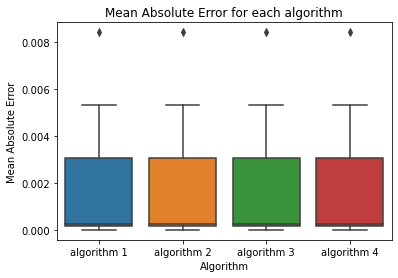

In [283]:
#BOX-PLOT MEAN AVERAGE ERROR


dataframe_mae = pd.DataFrame(all_mae[0], columns=[names[0]]) 


for i in range(1, len(names)):
    data = np.random.normal(size=100)
    dataframe_mae.insert(i, names[i], all_mae[0], True)


ax = sns.boxplot(data=dataframe_mae);
ax.set_xlabel("Algorithm")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("Mean Absolute Error for each algorithm")
plt.show()

[[211, 155, 279, 243, 41, 207, 63, 45, 121, 23], [1271, 87, 681, 265, 1355, 569, 181, 281, 221, 181], [63, 21, 63, 21, 63, 37, 15, 63, 63, 63], [99, 63, 53, 63, 101, 53, 93, 53, 69, 49]]


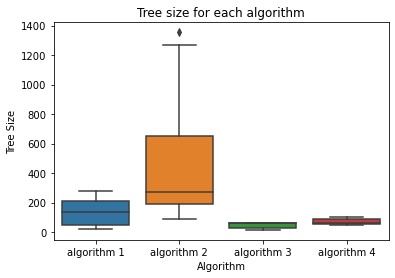

In [284]:
#BOX-PLOT TREE SIZE

dataframe_tree_size = pd.DataFrame(all_tree_size[0], columns=[names[0]]) 

for i in range(1, len(names)):
    data = np.random.normal(size=100)
    dataframe_tree_size.insert(i, names[i], all_tree_size[i], True)

print(all_tree_size)

ax = sns.boxplot(data=dataframe_tree_size);
ax.set_xlabel("Algorithm")
ax.set_ylabel("Tree Size")
ax.set_title("Tree size for each algorithm")
plt.show()

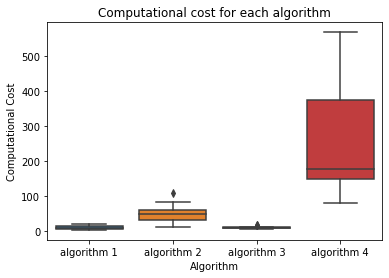

In [285]:
#BOX-PLOT COMPUTATIONAL COST


dataframe_comp_cost = pd.DataFrame(all_comp_cost[0], columns=[names[0]]) 

for i in range(1, len(names)):
    data = np.random.normal(size=100)
    dataframe_comp_cost.insert(i, names[i], all_comp_cost[i], True)

ax = sns.boxplot(data=dataframe_comp_cost);
ax.set_xlabel("Algorithm")
ax.set_ylabel("Computational Cost")
ax.set_title("Computational cost for each algorithm")
plt.show()

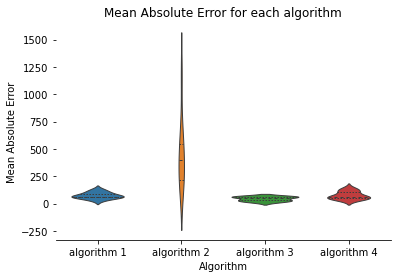

In [236]:
# Draw a nested violinplot and split the violins for easier comparison
ax = sns.violinplot(data=dataframe_mae,
               split=True, inner="quart", linewidth=1)
ax.set_xlabel("Algorithm")
ax.set_ylabel("Mean Absolute Error")
ax.set_title("Mean Absolute Error for each algorithm")
sns.despine(left=True)



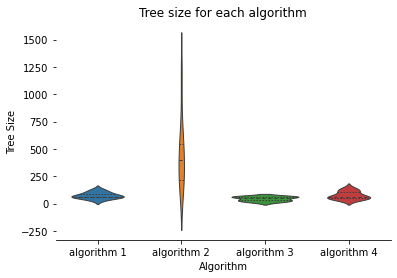

In [237]:
# Draw a nested violinplot and split the violins for easier comparison
ax = sns.violinplot(data=dataframe_tree_size,
               split=True, inner="quart", linewidth=1)
ax.set_xlabel("Algorithm")
ax.set_ylabel("Tree Size")
ax.set_title("Tree size for each algorithm")
sns.despine(left=True)

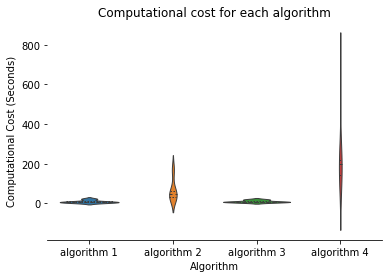

In [240]:
# Draw a nested violinplot and split the violins for easier comparison
ax = sns.violinplot(data=dataframe_comp_cost,
               split=True, inner="quart", linewidth=1)
ax.set_xlabel("Algorithm")
ax.set_ylabel("Computational Cost (Seconds)")
ax.set_title("Computational cost for each algorithm")
sns.despine(left=True)

In [211]:
from scipy import stats

#TEST STATISTICS

#DATA COLLECTED IN ARRAYS: all_mae, all_comp_cost, all_tree_size
#Indexs are each algorithm. E.g index 0 is algorithm 0, index 1 is algorithm 1, ......


In [213]:
test_statistics_tree_size = []

for i in range(len(names)):
    row = []
    for j in range(len(names)):
        if(i == j):
            row.append("nil")
        else:
            row.append(stats.ttest_ind(all_tree_size[i], all_tree_size[j]))
    
    test_statistics_tree_size.append(row)

test_statistics_tree_size_df = pd.DataFrame(test_statistics_tree_size)
test_statistics_tree_size_df

,0,1,2,3
0,nil,"(-3.799562774850861, 0.0013126685745817347)","(2.7320577528552477, 0.013685942523981877)","(-0.0963901269217826, 0.9242758267934714)"
1,"(3.799562774850861, 0.0013126685745817347)",nil,"(4.119775061228431, 0.0006432906516778644)","(3.776461036356481, 0.0013820126527856334)"
2,"(-2.7320577528552477, 0.013685942523981877)","(-4.119775061228431, 0.0006432906516778644)",nil,"(-2.4513165562286354, 0.024676250913813532)"
3,"(0.0963901269217826, 0.9242758267934714)","(-3.776461036356481, 0.0013820126527856334)","(2.4513165562286354, 0.024676250913813532)",nil


In [214]:
import numpy as numpy
import pandas as pd
#all_mae = [[7, 1, 3], [7, 2, 3], [7, 5, 3], [7, 5, 3]]

test_statistics_mae = []

for i in range(len(names)):
    row = []
    for j in range(len(names)):
        if(i == j):
            row.append("nil")
        else:
            row.append(stats.ttest_ind(all_mae[i], all_mae[j]))
    
    test_statistics_mae.append(row)

test_statistics_mae_df = pd.DataFrame(test_statistics_mae)
test_statistics_mae_df

,0,1,2,3
0,nil,"(2.170864204088531, 0.04355998758048626)","(1.121732029051616, 0.27671816242391645)","(0.11320938090173474, 0.9111176405529516)"
1,"(-2.170864204088531, 0.04355998758048626)",nil,"(-1.5245698537458874, 0.14474396151002547)","(-1.2866728308975335, 0.21451088426018078)"
2,"(-1.121732029051616, 0.27671816242391645)","(1.5245698537458874, 0.14474396151002547)",nil,"(-0.6665704169058361, 0.5135005539400488)"
3,"(-0.11320938090173474, 0.9111176405529516)","(1.2866728308975335, 0.21451088426018078)","(0.6665704169058361, 0.5135005539400488)",nil


In [234]:
test_statistics_comp_time = []

for i in range(len(names)):
    row = []
    for j in range(len(names)):
        if(i == j):
            row.append("nil")
        else:
            row.append(stats.ttest_ind(all_comp_cost[i], all_comp_cost[j]))
    
    test_statistics_comp_time.append(row)

test_statistics_comp_time_df = pd.DataFrame(test_statistics_comp_time)
test_statistics_comp_time_df

,0,1,2,3
0,nil,"(-3.246570561776272, 0.0044791211166380265)","(-0.36416295193820714, 0.7199789615248509)","(-4.198712007473424, 0.0005397608270450293)"
1,"(3.246570561776272, 0.0044791211166380265)",nil,"(3.196882586326096, 0.004996612277119568)","(-2.9132235865894645, 0.009276508033794624)"
2,"(0.36416295193820714, 0.7199789615248509)","(-3.196882586326096, 0.004996612277119568)",nil,"(-4.179854408377835, 0.0005628565501106241)"
3,"(4.198712007473424, 0.0005397608270450293)","(2.9132235865894645, 0.009276508033794624)","(4.179854408377835, 0.0005628565501106241)",nil
